In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pytensor.tensor as pt
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
import xarray as xr

sns.set_context('notebook')
sns.set_palette('husl')

The model here is that we have a *redshift-selected* sample of counterpart measurements, with perfect redshift measurements.  For each event, we measure an amplitude for the left-handed and right-handed waveforms, and the inclination and distance are related to our measurements by 
$$
A_{R/L} = f_{R/L} \frac{\left( 1 \pm \cos \iota \right)^2}{d} + N(0,1)
$$
where $f_{R/L}$ encode our detector network sensitivity to the different polarizations (if $f_{R/L} = 1$, then we fully measure both polarizations; if one is smaller than the other we are less sensitive to one of the polarizations).

We imagine that there is some additional selection effect imposed by the fact that we cannot make redshift measurements unless $x = \cos \iota > x_\mathrm{min}$---that is, there is some maximum viewing angle beyond which we cannot make redshift measurements.  But we don't *know* $x_\mathrm{min}$ (maybe we don't know theoretically the actual emission pattern that leads to detection/non-detection in the EM observations).  True parameters are here:

In [3]:
h_true = 0.7
dmax = 4/5
zmax = h_true*dmax

fr_true = 1.0
fl_true = 0.2

opening_angle_max = 50 # degrees
xmin = np.cos(opening_angle_max*np.pi/180) # 20-degree opening angle

Our pymc model for our measurements.  The distance is determined by integrating the distance prior (normalized to the selected sample) 
$$
p\left( d \right) = \frac{3 d^2}{d_\mathrm{max}^3} = \frac{3 d^2}{z_\mathrm{max}^3 / h^3}
$$
against a delta-function likelihood for the perfect measurement of $z$:
$$
\int \mathrm{d} d \, \frac{3 d^2}{z_\mathrm{max}^3 / h^3} \delta \left( z - d h\right) = \frac{3 z^3}{z_\mathrm{max}^3}
$$
Since $z$ is assumed known perfectly (i.e. it is part of the observed data), this is an overall constant in the posterior.

In [4]:
def make_model(fl, fr, Al, Ar, z, zmax, x_prior_limits=None):
    N = Al.shape[0]
    event_index = np.arange(N)
    if x_prior_limits is None:
        xpl = -1.0
        xph = 1.0
    else:
        xpl, xph = x_prior_limits
    with pm.Model(coords={'event_index': event_index}) as model:
        h = pm.Uniform('h', lower=0.35, upper=1.4)
        xmin = pm.Uniform('xmin', lower=xpl, upper=xph)

        x = pm.Uniform('x', lower=xmin, upper=1, dims='event_index')

        d = pm.Deterministic('d', z / h, dims='event_index')
        # There is no weighting here because it is all constant: \int d(d) \, 3 d^2 / (zmax/h)^3 delta(z - d h) = const

        _ = pm.Normal('Ar', mu=fr*pt.square(1 + x)/d, sigma=1, observed=Ar, dims='event_index')
        _ = pm.Normal('Al', mu=fl*pt.square(1 - x)/d, sigma=1, observed=Al, dims='event_index')
    return model


Draw some observations:

In [5]:
N = 128
xs_true = np.random.uniform(low=xmin, high=1, size=N)
ds_true = np.cbrt(np.random.uniform(low=0, high=dmax*dmax*dmax, size=N))
zs_true = h_true*ds_true

Ar_true = np.square(1+xs_true)/ds_true*fr_true
Al_true = np.square(1-xs_true)/ds_true*fl_true

Ar = np.random.normal(loc=Ar_true, scale=1)
Al = np.random.normal(loc=Al_true, scale=1)

They seem to follow the right distance distribution and the right inclination distribution:

Text(0.5, 12.44444444444443, '$x$')

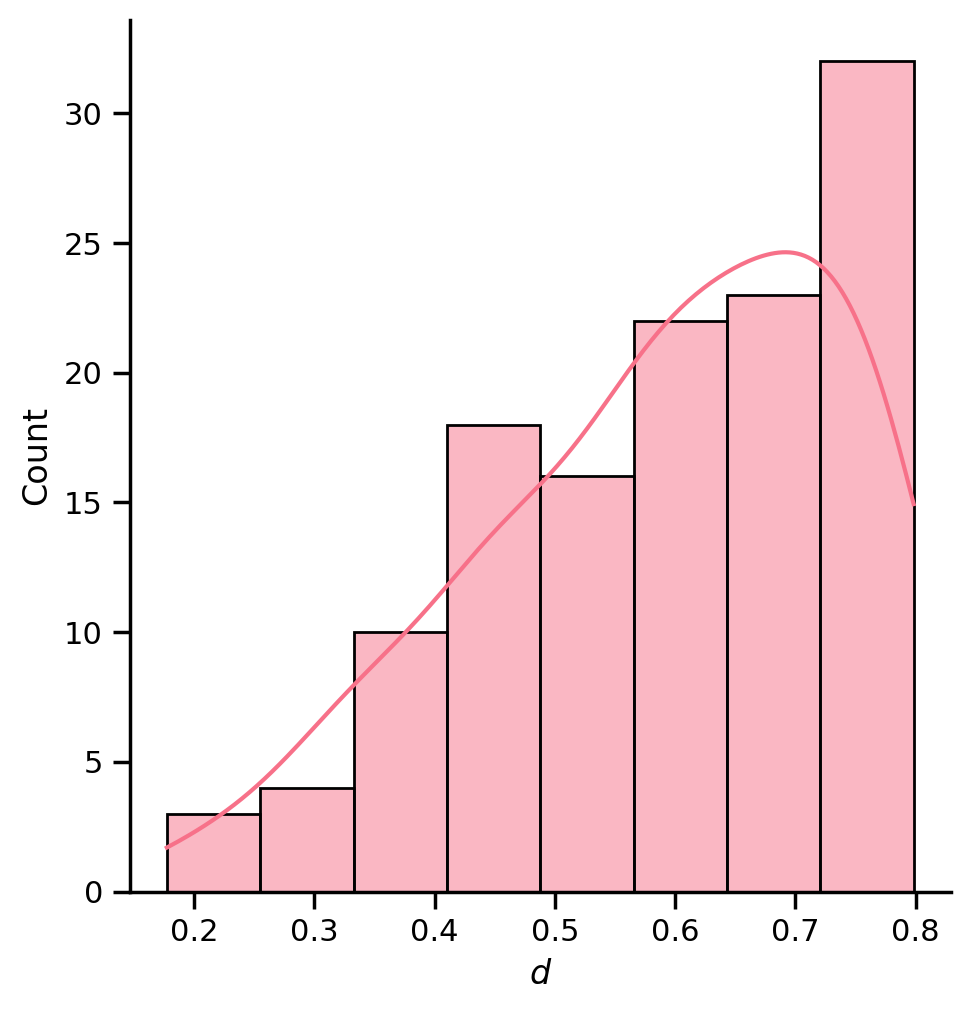

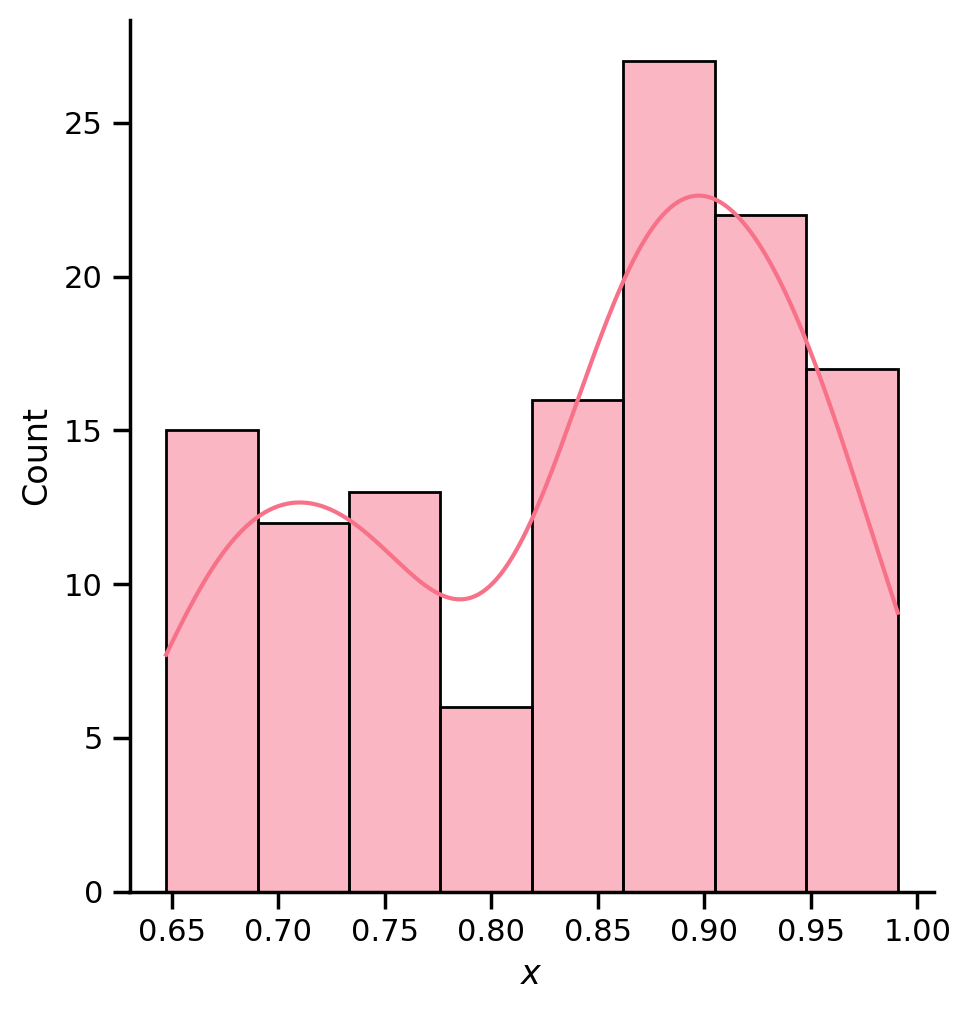

In [6]:
sns.displot(ds_true, kde=True)
plt.xlabel(r'$d$')

sns.displot(xs_true, kde=True)
plt.xlabel(r'$x$')

Let's fit them:

In [7]:
model = make_model(fl_true, fr_true, Al, Ar, zs_true, zmax)

In [8]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, xmin, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Let's simulate the inferred distribution of $x$ values:

In [9]:
xs = np.random.uniform(low=trace.posterior['xmin'], high=1)
trace.posterior['x_draw'] = xr.DataArray(xs, dims=['chain', 'draw'], coords={'chain': trace.posterior.chain, 'draw': trace.posterior.draw})

And we see that we infer the true density of $x$ pretty well: flat at large $x$, and falling off in the region of our uncertainty about $x_\mathrm{min}$.

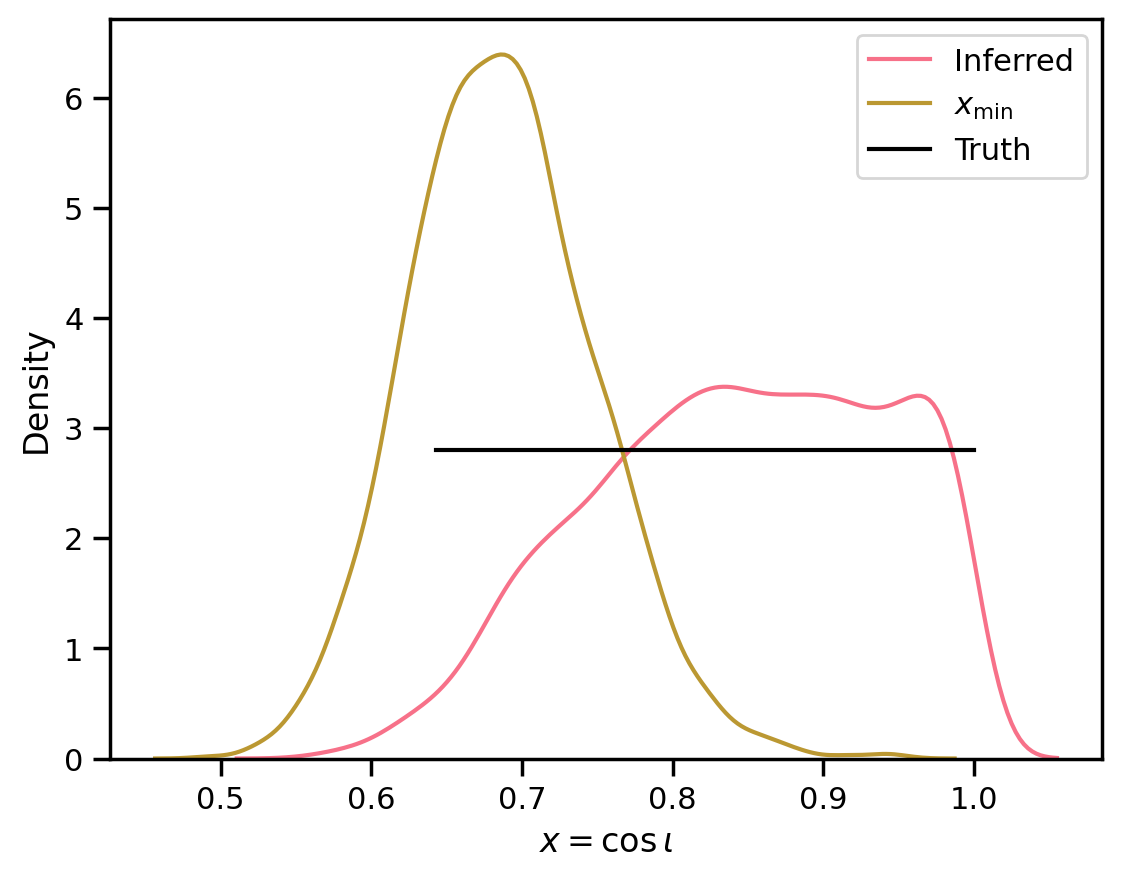

In [10]:
sns.kdeplot(trace.posterior.x_draw.values.flatten(), label='Inferred')
x = np.linspace(xmin, 1, 1024)
sns.kdeplot(trace.posterior.xmin.values.flatten(), label=r'$x_\mathrm{min}$')
plt.plot(x, 1/(1-xmin)*np.ones_like(x), color='k', label='Truth')
plt.xlabel(r'$x = \cos \iota$')
plt.legend()

array([[<AxesSubplot: title={'center': 'h'}>,
        <AxesSubplot: title={'center': 'h'}>],
       [<AxesSubplot: title={'center': 'xmin'}>,
        <AxesSubplot: title={'center': 'xmin'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>]], dtype=object)

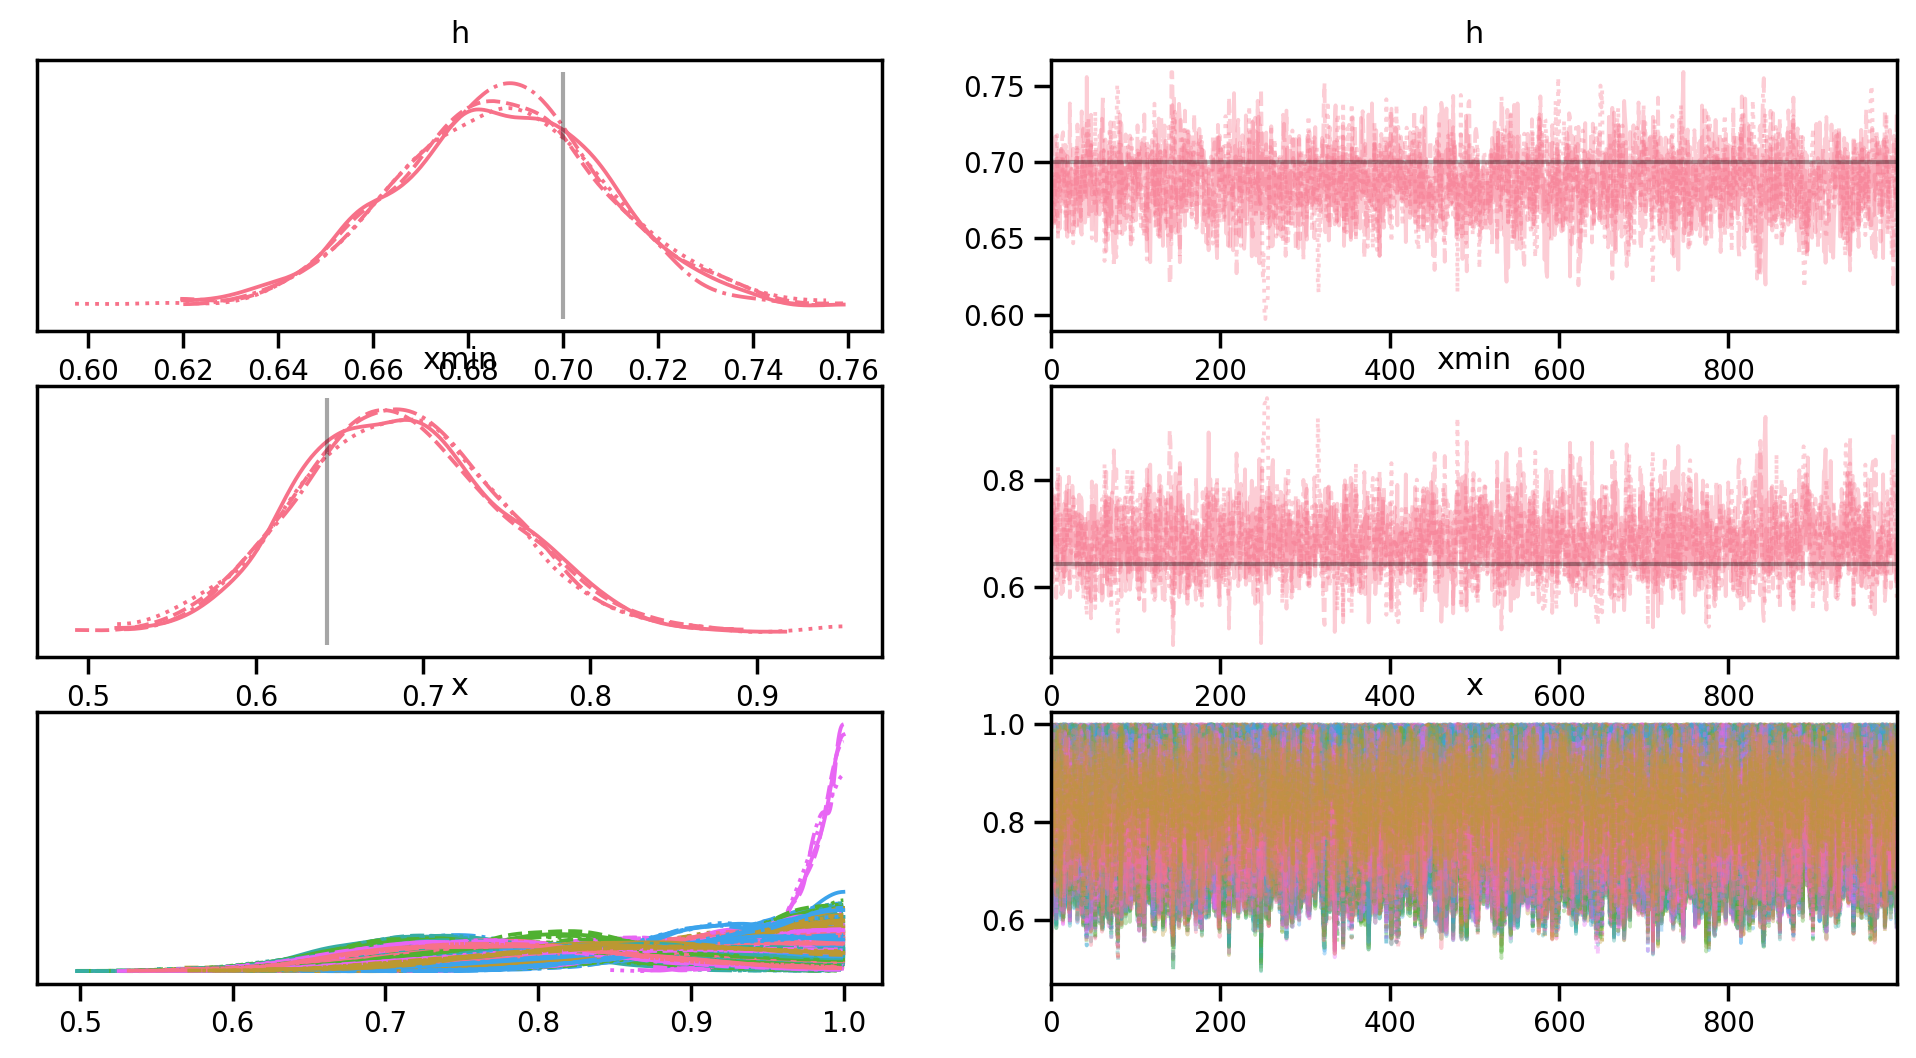

In [11]:
az.plot_trace(trace, var_names=['h', 'xmin', 'x'], lines=[('h', {}, h_true), ('xmin', {}, xmin)])

We can see that $h$ and $x_\mathrm{min}$ are correlated, so if we don't measure $x_\mathrm{min}$ properly, we will have systematic bias in $h$:

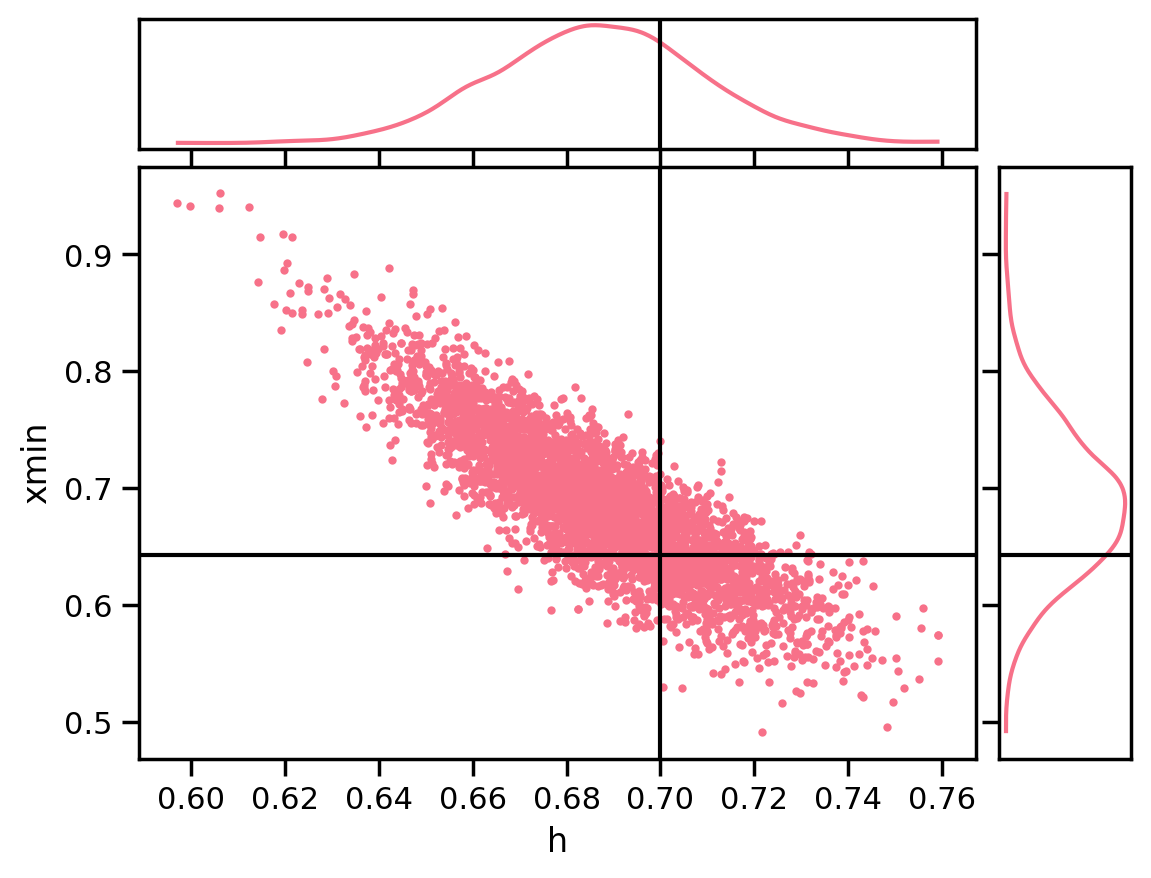

In [12]:
s = az.plot_pair(trace, var_names=['h', 'xmin'], marginals=True)
s[0,0].axvline(h_true, color='k')
s[1,0].axvline(h_true, color='k')
s[1,0].axhline(xmin, color='k')
s[1,1].axhline(xmin, color='k')

What if we *don't* fit out the EM selection effects?  Here we assume the uniform inclination prior for our observations (i.e. we fix $x_\mathrm{min} = -1$).

In [13]:
with make_model(fl_true, fr_true, Al, Ar, zs_true, zmax, x_prior_limits=(-1.0, -0.99)) as bad_model:
    bad_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, xmin, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<AxesSubplot: title={'center': 'h'}>,
        <AxesSubplot: title={'center': 'h'}>],
       [<AxesSubplot: title={'center': 'xmin'}>,
        <AxesSubplot: title={'center': 'xmin'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>]], dtype=object)

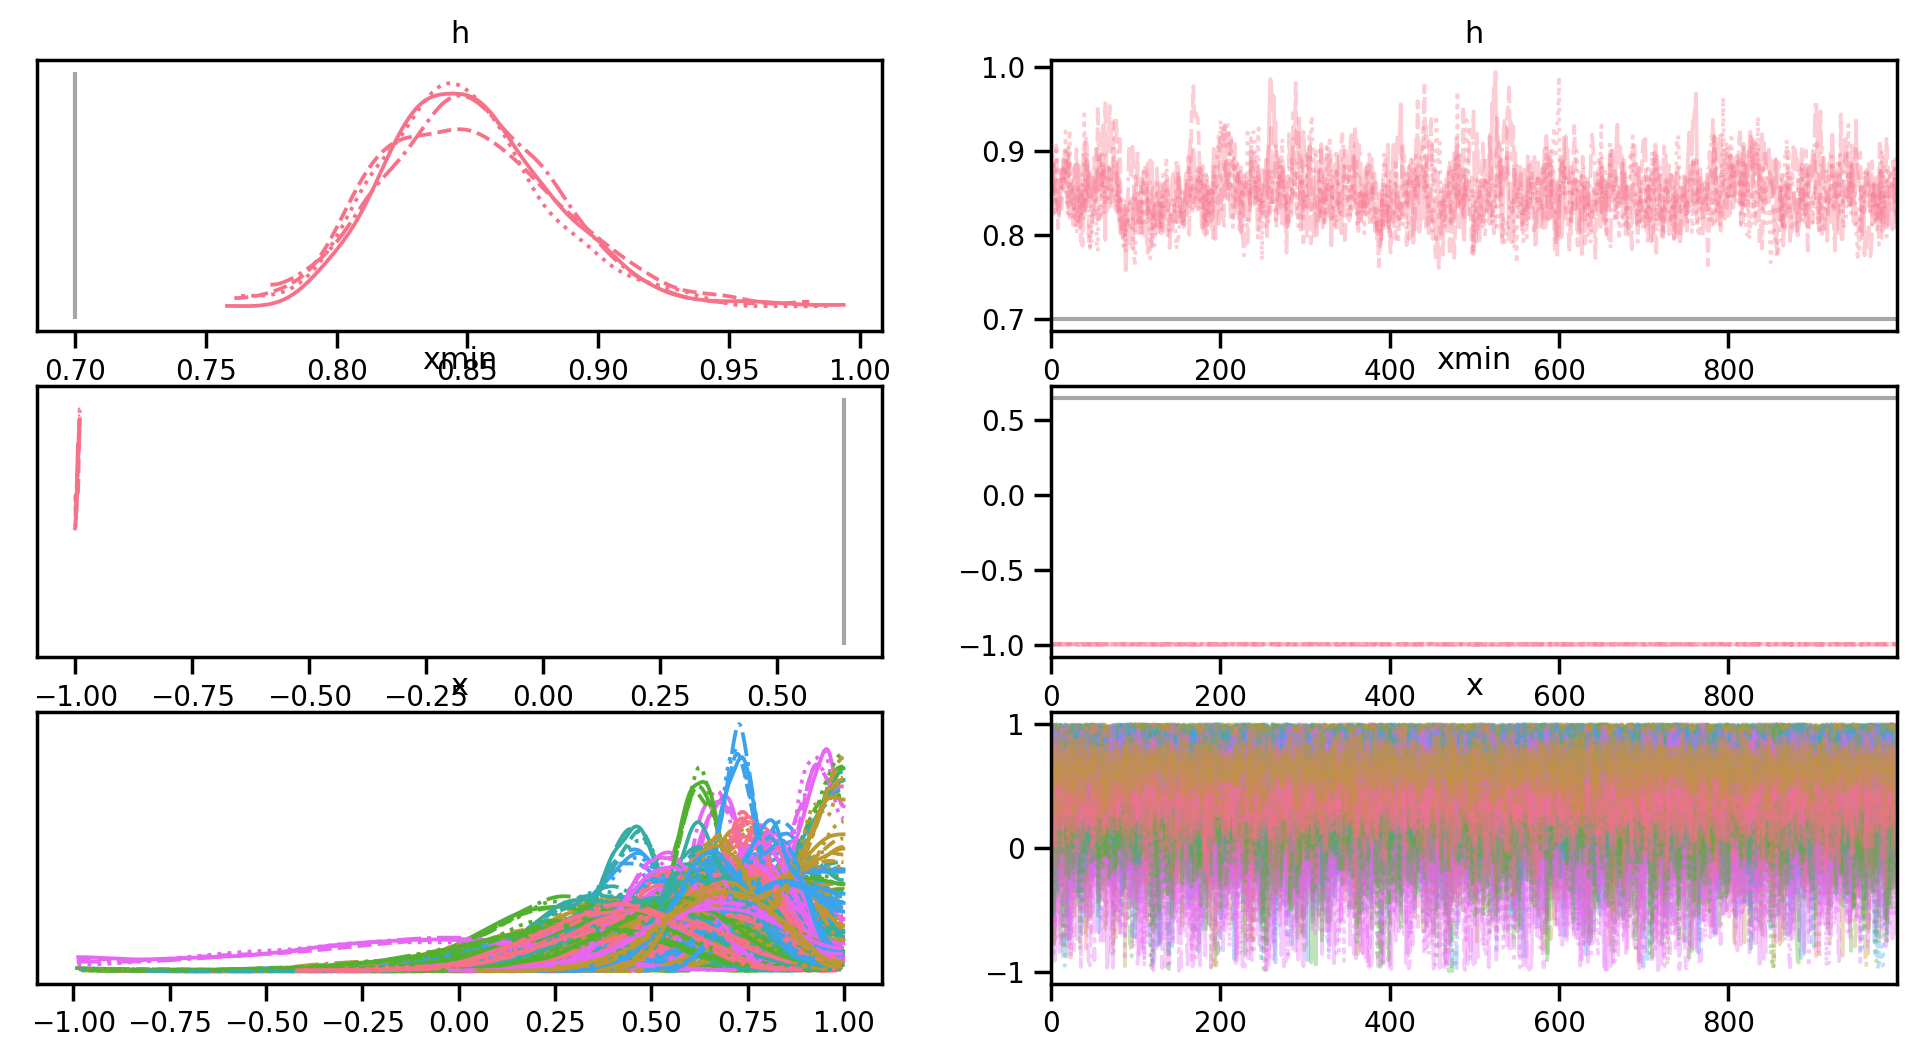

In [14]:
az.plot_trace(bad_trace, var_names=['h', 'xmin', 'x'], lines=[('h', {}, h_true), ('xmin', {}, xmin)])

We see that our cosmological inferences will be very biased if we don't account for the inclination selection function:

Text(0, 0.5, '$d$')

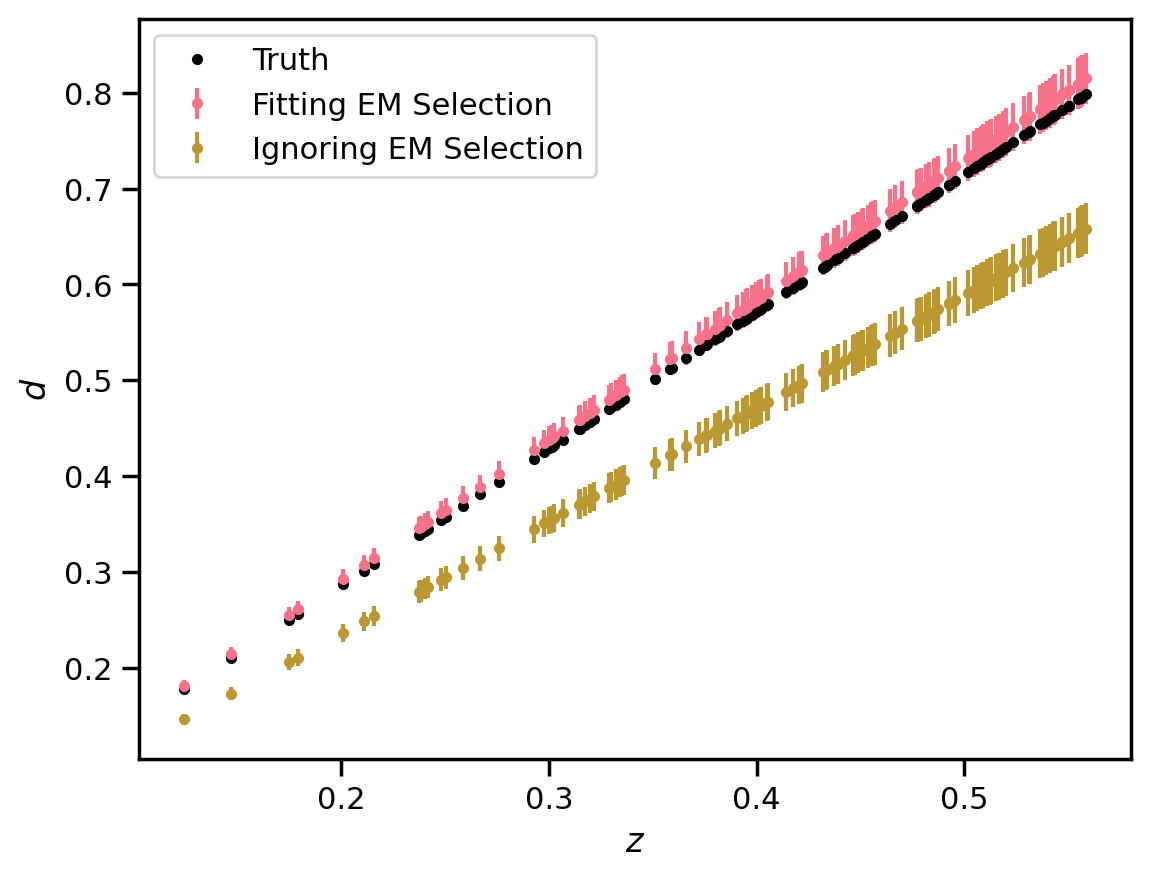

In [15]:
plt.errorbar(zs_true, trace.posterior['d'].mean(dim=('chain', 'draw')), yerr=trace.posterior['d'].std(dim=('chain', 'draw')), fmt='.', label='Fitting EM Selection')
plt.errorbar(zs_true, bad_trace.posterior['d'].mean(dim=('chain', 'draw')), yerr=trace.posterior['d'].std(dim=('chain', 'draw')), fmt='.', label='Ignoring EM Selection')
plt.plot(zs_true, ds_true, '.k', label='Truth')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$d$')

If we *don't* use the EM redshift measurement, you can see that our inferences on $d$ and $x$ are correlated much like actual measurements:

In [16]:
i = np.random.randint(N)
print(f'Sampling event {i}')
with pm.Model() as event_model:
    d3 = pm.Uniform('d3', lower=0, upper=dmax*dmax*dmax)
    d = pm.Deterministic('d', d3**(1/3))

    x = pm.Uniform('x', lower=-1, upper=1)

    _ = pm.Normal('Ar', mu=fr_true*pt.square(1+x)/d, sigma=1, observed=Ar[i])
    _ = pm.Normal('Al', mu=fl_true*pt.square(1-x)/d, sigma=1, observed=Al[i])

    event_trace = pm.sample()

Sampling event 96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d3, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<AxesSubplot: >, None],
       [<AxesSubplot: xlabel='d', ylabel='x'>, <AxesSubplot: >]],
      dtype=object)

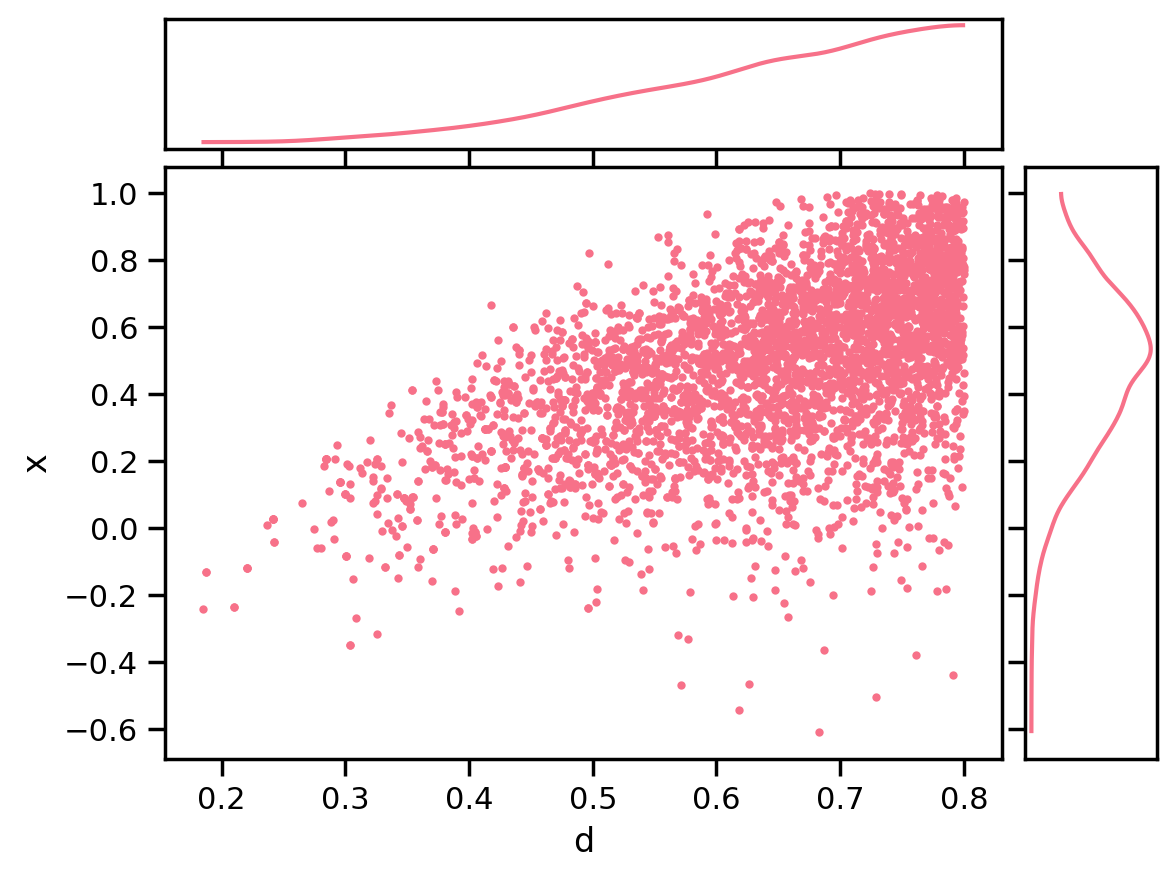

In [17]:
az.plot_pair(event_trace, var_names=['d', 'x'], marginals=True)